In [1]:
#import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, vmap
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
# the portion of parameter space to look at
# be sure that it cover a sensible portion of the distributions, otherwise the normalization constants will be off
theta_window = ((-5, 5),(-5,5))
window_pixels = 100

theta1_grid = jnp.linspace(theta_window[0][0], theta_window[0][1], window_pixels)
theta2_grid = jnp.linspace(theta_window[1][0], theta_window[0][1], window_pixels)
theta_grid = jnp.array(jnp.meshgrid(theta1_grid, theta2_grid))
theta_grid_vector = theta_grid.reshape(2, window_pixels**2)

In [23]:
def mesh_fun_of_theta(fun, title=None, colorbar=True, new_figure=True):
    if new_figure:
        plt.figure(figsize=(7, 7))


    values = vmap(fun, in_axes=1)(theta_grid_vector).reshape((window_pixels,window_pixels))
    plt.contourf(theta1_grid, theta2_grid, values, cmap=plt.cm.jet)

    if colorbar:
        plt.colorbar()
    if title is not None:
        plt.title(title)

def plot_vector_field_of_theta(vector_field, title=None, new_figure=True, scale=1, window_pixels=window_pixels):
    if new_figure:
        plt.figure(figsize=(10, 10))

    theta1_grid = jnp.linspace(theta_window[0][0], theta_window[0][1], window_pixels)
    theta2_grid = jnp.linspace(theta_window[1][0], theta_window[0][1], window_pixels)
    theta_grid = jnp.array(jnp.meshgrid(theta1_grid, theta2_grid))
    theta_grid_vector = theta_grid.reshape(2, window_pixels**2)

    arrows = vmap(vector_field, in_axes=1)(theta_grid_vector)

    thetas_and_arrows = jnp.concatenate(
        [jnp.moveaxis(theta_grid_vector, 0, 1), arrows],
        axis=1)

    for theta_and_arrow in thetas_and_arrows:
        plt.arrow(theta_and_arrow[0], theta_and_arrow[1],
                  scale*theta_and_arrow[2], scale*theta_and_arrow[3],
                  color='k', width=0.02, alpha=0.4
        )

    plt.xlim([theta_window[0][0]-1, theta_window[0][1]+1])
    plt.ylim([theta_window[1][0]-1, theta_window[1][1]+1])
    if title is not None:
        plt.title(title)


def plot_metric_field_of_theta(metric_field, title=None, scale=1, window_pixels=window_pixels):
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)

    theta1_grid = jnp.linspace(theta_window[0][0], theta_window[0][1], window_pixels)
    theta2_grid = jnp.linspace(theta_window[1][0], theta_window[0][1], window_pixels)
    theta_grid = jnp.array(jnp.meshgrid(theta1_grid, theta2_grid))
    theta_grid_vector = theta_grid.reshape(2, window_pixels**2)

    metrics = vmap(metric_field, in_axes=1)(theta_grid_vector)
    theta_grid_vector = jnp.moveaxis(theta_grid_vector, 0, 1)

    for i in range(window_pixels**2):
        theta = theta_grid_vector[i]
        metric = metrics[i]

        eigenval, eigenvec = jnp.linalg.eigh(metric)
        norm0, norm1 = scale*(jnp.sqrt(eigenval[0])), scale*(jnp.sqrt(eigenval[1]))
        angle = -jnp.rad2deg(jnp.arctan(eigenvec[0][0]/eigenvec[0][1]))
        ellipse = Ellipse(xy=theta, height=norm0, width=norm1, angle=angle, lw=0.5, fill=False)
        ax.add_patch(ellipse)

    plt.xlim([theta_window[0][0]-1, theta_window[0][1]+1])
    plt.ylim([theta_window[1][0]-1, theta_window[1][1]+1])
    if title is not None:
        plt.title(title)
    plt.show()

## Neural Network

In [4]:
# RELU network
def NN_relu(theta, x):
    assert theta.shape == ((2,))
    return theta[1] * jnp.maximum(theta[0] * x, 0)

# Tanh network
def NN_tanh(theta, x):
    assert theta.shape == ((2,))
    return theta[1] * jnp.tanh(theta[0] * x)

NN = NN_relu
#NN = NN_tanh

## Bayesian functions

In [5]:
# hyperparameters
prior_precision = 1
target_precision = 1

In [6]:
def log_prior(theta):
    return - 0.5 * prior_precision * (theta[0]**2 + theta[1]**2) - jnp.log(2 * jnp.pi) + jnp.log(prior_precision)

def log_prior(theta):
    # alternative implementation
    # CONS: slower, less precise
    # PRO: allows to set prior_precision = 0
    unnormalized_log_prior = lambda theta: - 0.5 * prior_precision * (theta[0]**2 + theta[1]**2)
    vmap_unnormalized_log_prior = vmap(unnormalized_log_prior, in_axes=1)
    normalization = jax.scipy.special.logsumexp(vmap_unnormalized_log_prior(theta_grid_vector))
    return unnormalized_log_prior(theta) - normalization

def log_likelihood(theta, dataset):
    f_theta = lambda x: NN(theta,x)
    def log_likelihood_single_data(x_and_target):
        assert x_and_target.shape == (2,)
        x, target = x_and_target
        return - 0.5 * target_precision * (f_theta(x) - target)**2 - jnp.log(2 * jnp.pi) + jnp.log(target_precision)
    log_likelihoods = vmap(log_likelihood_single_data, in_axes=0)(dataset)
    return jnp.sum(log_likelihoods, axis=0)

def log_evidence(dataset):
    log_lik_plus_prior = lambda theta: log_prior(theta) + log_likelihood(theta, dataset)
    log_lik_plus_prior = vmap(log_lik_plus_prior, in_axes=1)
    return jax.scipy.special.logsumexp(log_lik_plus_prior(theta_grid_vector))

def log_posterior(theta, dataset):
    return log_prior(theta) + log_likelihood(theta, dataset) - log_evidence(dataset)

def prior(theta):
    return jnp.exp(log_prior(theta))

def likelihood(theta, dataset):
    return jnp.exp(log_likelihood(theta, dataset))

def evidence(dataset):
    return jnp.exp(log_evidence(dataset))

def posterior(theta, dataset):
    return jnp.exp(log_posterior(theta, dataset))

## Dataset

(10, 2)


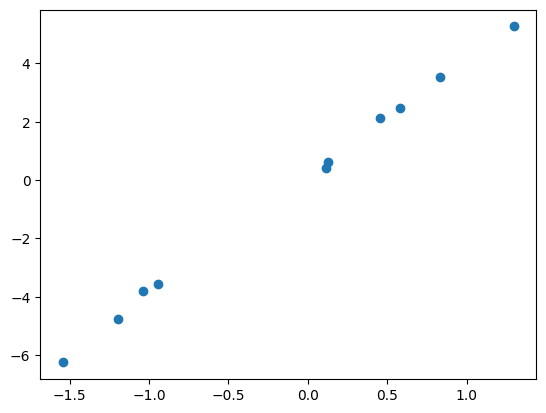

In [7]:
dataset_size = 10
slope = 4
noise = 0.2

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
xs = jax.random.normal(subkey, shape=(dataset_size,)) + 0.5
#xs = jax.random.uniform(subkey, shape=(dataset_size,))
key, subkey = jax.random.split(key)
targets_noise = noise * jax.random.normal(subkey, shape=(dataset_size,))
targets = slope * xs + targets_noise
plt.scatter(xs, targets)
dataset = jnp.stack([xs, targets], axis=1)
print(dataset.shape)

## Some plots over parameter space

### Prior, likelihood and posterior

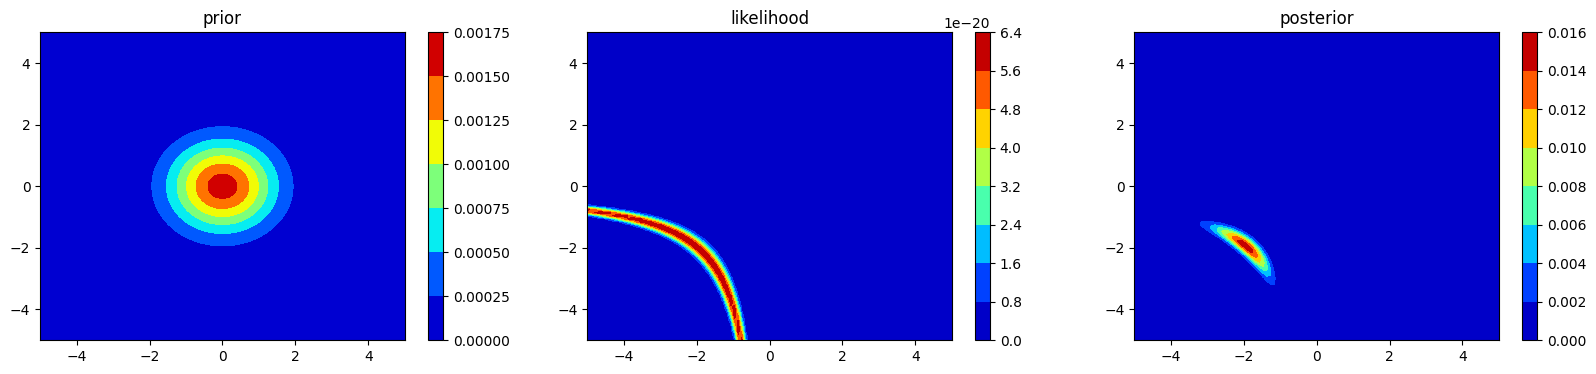

In [8]:
likelihood_dataset = lambda theta: likelihood(theta, dataset)
posterior_dataset = lambda theta: posterior(theta, dataset)

plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
mesh_fun_of_theta(prior, title='prior', new_figure=False)
plt.subplot(1, 3, 2)
mesh_fun_of_theta(likelihood_dataset, title='likelihood', new_figure=False)
plt.subplot(1, 3, 3)
mesh_fun_of_theta(posterior_dataset, title='posterior', new_figure=False)

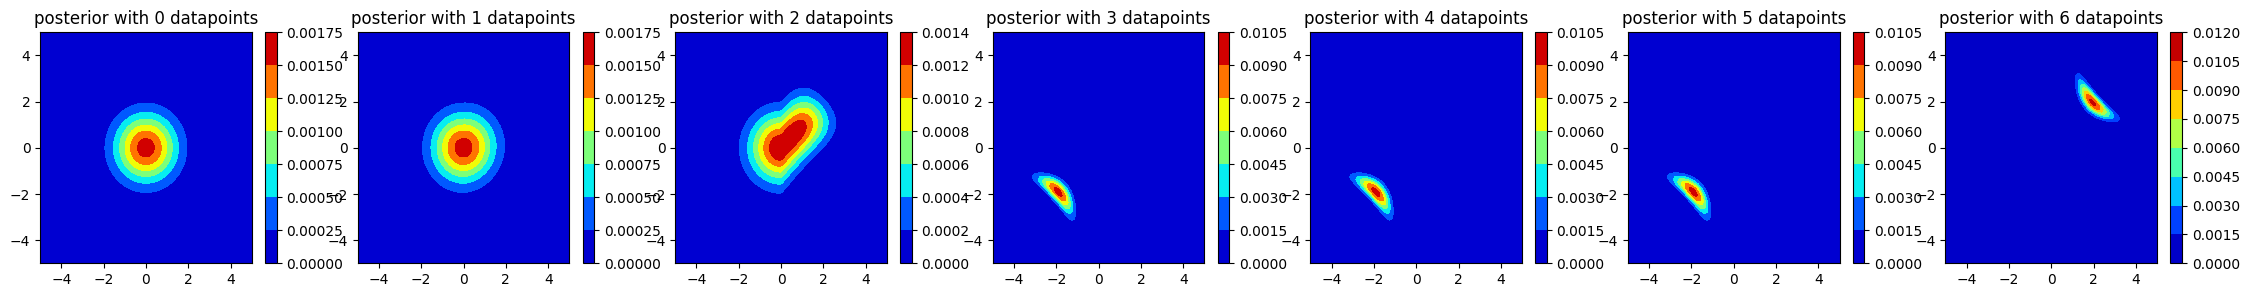

In [15]:
# choose how many to plot
points_to_add = 7
#points_to_add = dataset_size

assert points_to_add <= dataset_size
plt.figure(figsize=(4*points_to_add, 3))
for d in range(points_to_add):
    reduced_dataset = dataset[:d]
    posterior_reduced_dataset = lambda theta: posterior(theta, reduced_dataset)
    plt.subplot(1, points_to_add, d+1)
    mesh_fun_of_theta(posterior_reduced_dataset, title=f"posterior with {d} datapoints", new_figure=False)

## Metric

In [16]:

theta = jnp.array((3., 3.))


NN_of_x = lambda x: lambda theta: NN(theta,x)
NN_of_theta = lambda theta: lambda x: NN(theta,x)


def jacobian_wrt_theta(theta, x):
    return grad(lambda theta: NN(theta, x))(theta)

def generalized_gauss_newton(theta, xs):
    jacobian_fun = lambda x: jacobian_wrt_theta(theta, x)
    jacobians = vmap(jacobian_fun, in_axes=0)(xs)
    ggn = jnp.einsum("bi, bj -> ij", jacobians, jacobians) * target_precision
    ggn += prior_precision * jnp.eye(2)
    return ggn

def gradient_wrt_theta(theta, dataset):
    NN_theta = lambda x: NN(theta,x)
    xs = dataset[:, 0]
    targets = dataset[:, 1]
    predictions = vmap(NN_theta, in_axes=0)(xs)
    residuals = predictions - targets
    jacobians = vmap(lambda x: jacobian_wrt_theta(theta, x), in_axes=0)(xs)
    gradient = - jnp.einsum("bi, b -> i", jacobians, residuals) * target_precision
    gradient -= prior_precision * theta
    return gradient

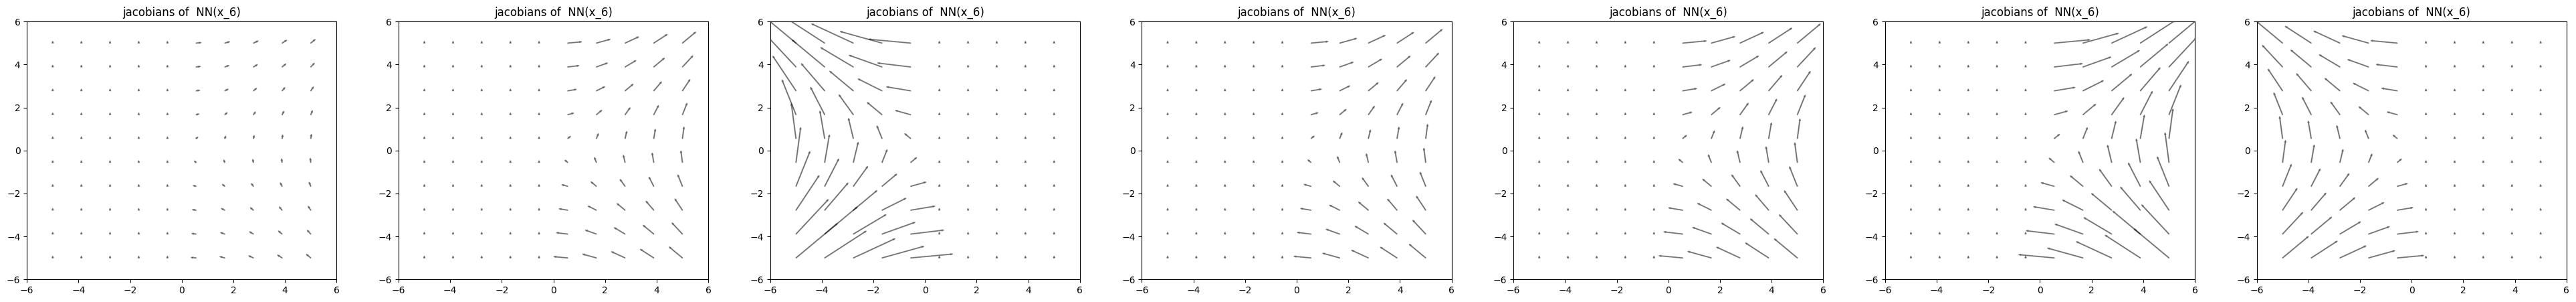

In [17]:
# choose how many to plot
points_to_plot = 7
#points_to_plot = dataset_size

assert points_to_plot <= dataset_size
plt.figure(figsize=(7*points_to_plot, 5))
for idx in range(points_to_plot):
    plt.subplot(1, points_to_add, idx+1)
    x = dataset[idx, 0]
    jacobian_fun = lambda theta: jacobian_wrt_theta(theta, x)
    plot_vector_field_of_theta(jacobian_fun, title=f"jacobians of  NN(x_{d})", new_figure=False, scale=0.2, window_pixels=10)

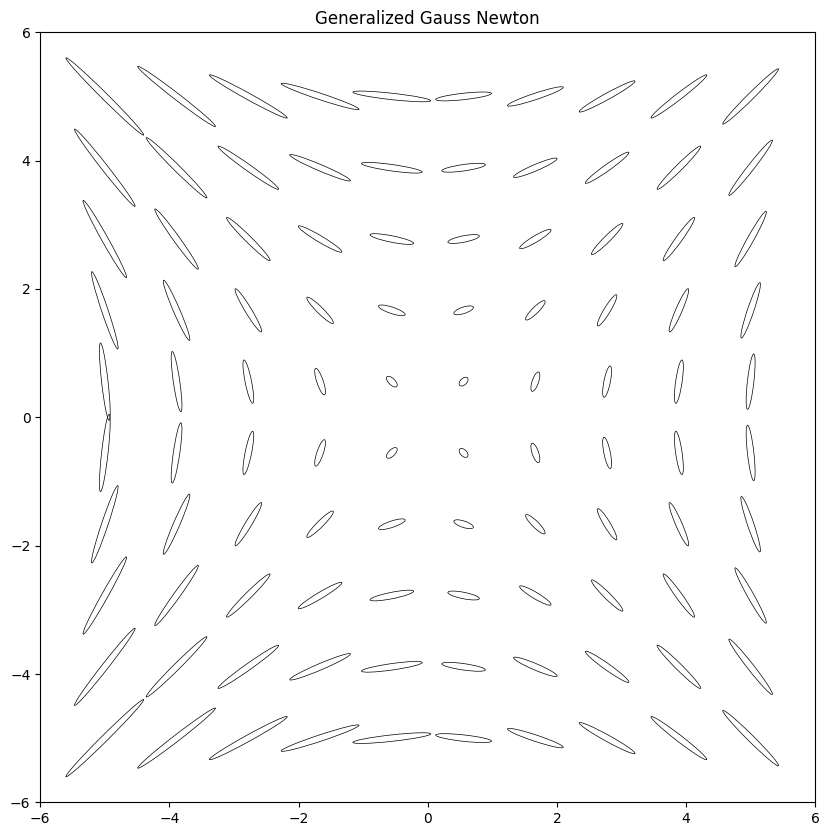

In [24]:
ggn_fun = lambda theta: generalized_gauss_newton(theta, dataset[:, 0])
plot_metric_field_of_theta(ggn_fun, title="Generalized Gauss Newton", scale=0.1, window_pixels=10)

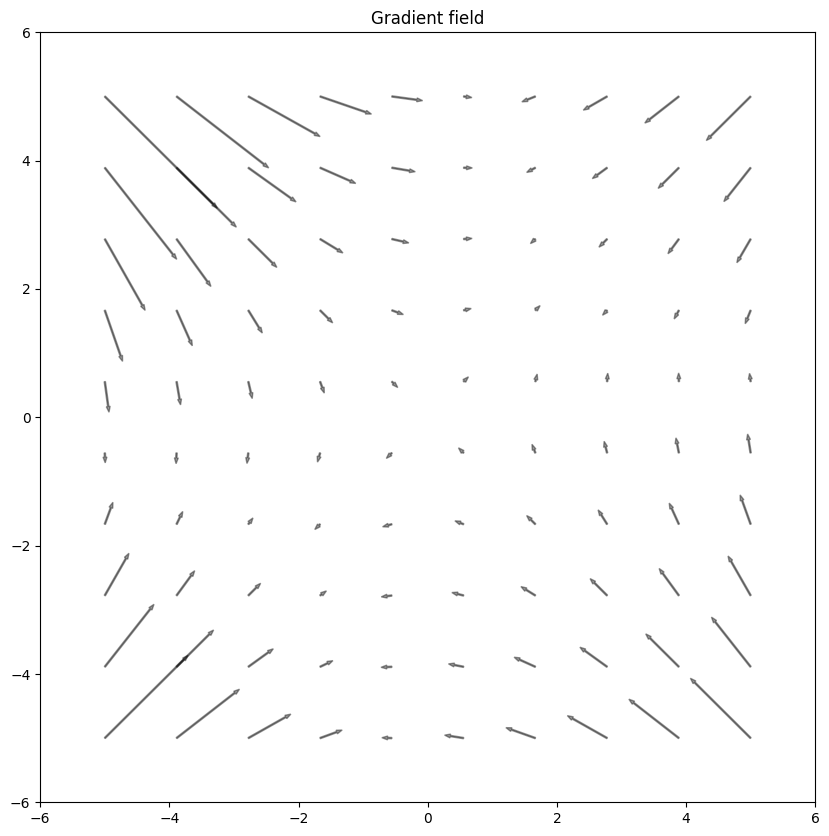

In [14]:
gradient_fun = lambda theta: gradient_wrt_theta(theta, dataset)
plot_vector_field_of_theta(gradient_fun, title="Gradient field", new_figure=True, scale=0.002, window_pixels=10)

## MAP Train

MAP = [1.9594647 1.959459 ]


(-1.0, 4.0)

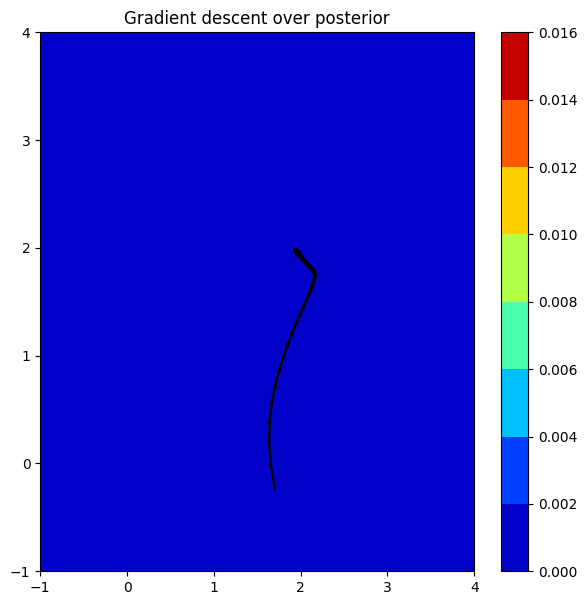

In [25]:
learning_rate = 0.01
number_of_steps = 1000


mesh_fun_of_theta(posterior_dataset, new_figure=True, title='Gradient descent over posterior')


key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
theta = jax.random.normal(subkey, shape=(2,))

for step in range(number_of_steps):
  gradient = gradient_wrt_theta(theta, dataset)
  plt.arrow(*theta, *(learning_rate*gradient), color='k', width=0.01, alpha=1)
  theta += learning_rate * gradient


theta_MAP = theta
# plot a star in the final point
plt.scatter(*theta_MAP, marker="*", c='k')
print('MAP =', theta_MAP)

plt.xlim([-1,4])
plt.ylim([-1,4])

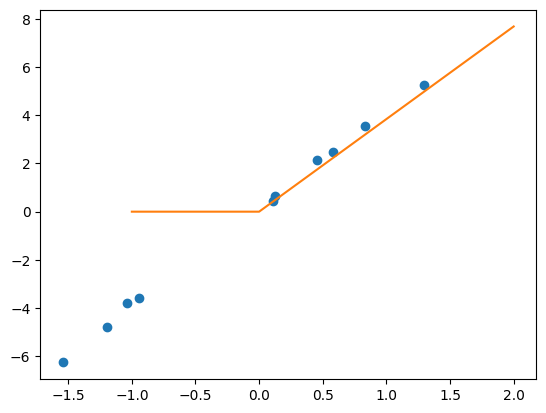

In [26]:
plt.scatter(xs, targets)
x_linspace = jnp.linspace(-1, 2, window_pixels)
preds_linspace = vmap(lambda x : NN(theta_MAP, x))(x_linspace)
plt.plot(x_linspace, preds_linspace, c="C1")

## Random Walks

In [27]:
def metric_sample(theta, key):
  key, subkey = jax.random.split(key)
  eps = jax.random.normal(subkey, shape=(2,))

  ggn = generalized_gauss_newton(theta, dataset[:, 0])
  eigenval, eigenvec = jnp.linalg.eigh(ggn)
  sqrt_inv_ggn_times_eps = jnp.einsum("ki, i, ij, j -> k", eigenvec,1./jnp.sqrt(eigenval), eigenvec, eps)
  return sqrt_inv_ggn_times_eps, key



In [28]:
num_step = 400
step_size = 0.05
step_size = 1./jnp.sqrt(num_step)
# keep sqrt(step_num)*step_size = 1 to preserve the variance of the samples (?)

## Visualize N paths

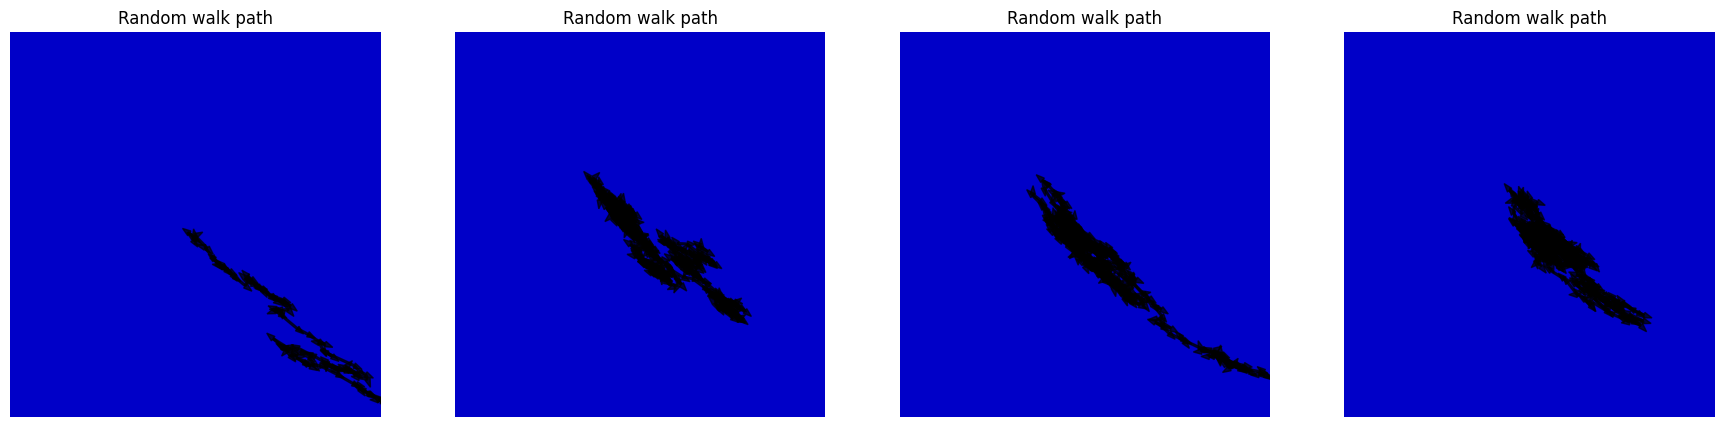

In [29]:
N = 4

plt.figure(figsize=(5.5*N, 5))
for n in range(N):
  plt.subplot(1, N, n+1)
  mesh_fun_of_theta(posterior_dataset, new_figure=False, colorbar=False, title='Random walk path')
  plt.axis('off')

  theta = jnp.copy(theta_MAP)
  for step in range(num_step):
    direction, key = metric_sample(theta, key)
    step = step_size * direction
    plt.arrow(*theta, *step, color='k', width=0.01, alpha=0.7)
    theta += step


  plt.xlim([1,3])
  plt.ylim([1,3])

## Visualize endpoints

(0.0, 4.0)

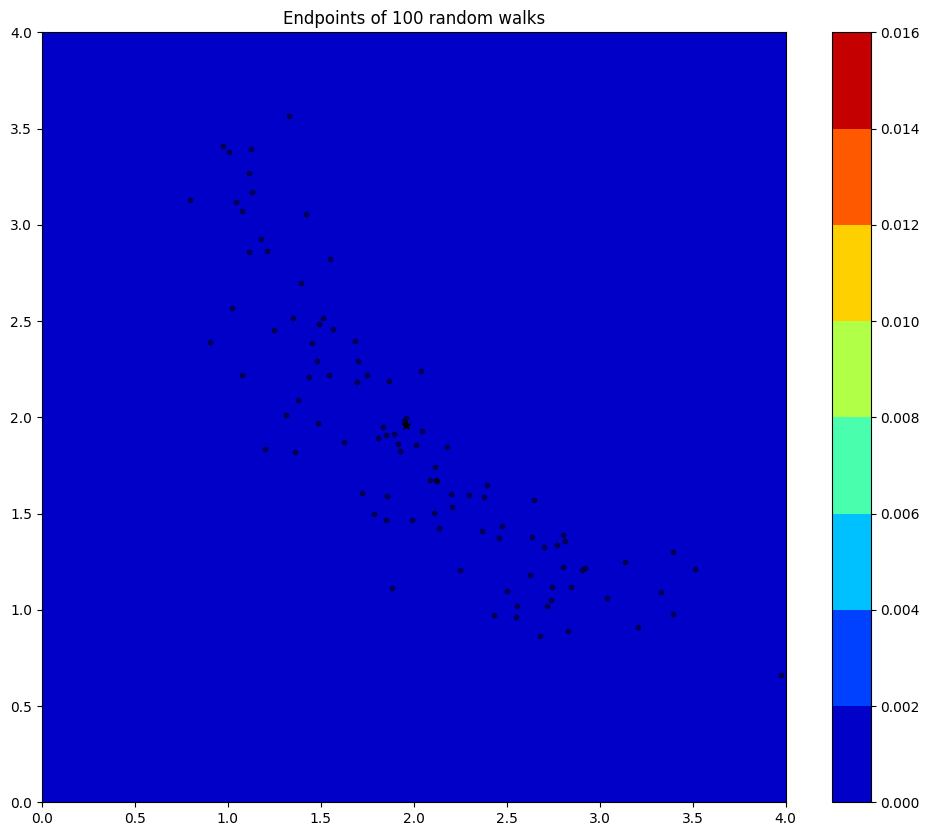

In [30]:
N = 100

plt.figure(figsize=(12, 10))
mesh_fun_of_theta(posterior_dataset, new_figure=False, title=f"Endpoints of {N} random walks")


for n in range(N):
  theta = jnp.copy(theta_MAP)
  for step in range(num_step):
    direction, key = metric_sample(theta, key)
    step = step_size * direction
    theta += step
  plt.scatter(*theta, marker='.', c='k', s=40, alpha=0.5)

plt.scatter(*theta_MAP, marker="*", c='k')
plt.xlim([0,4])
plt.ylim([0,4])

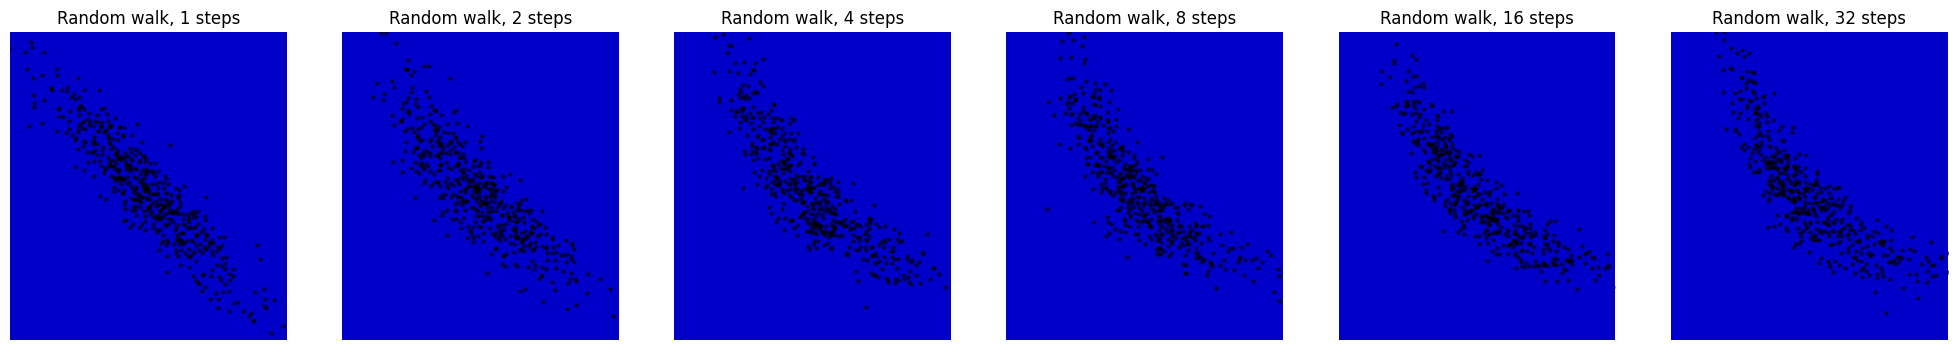

In [31]:
#visualize the endpoints of N paths, when varing number of steps (keeping sqrt(step_num)*step_size = 1)
### NOTE: 1 step equals to sampling from standard Laplace Approx

N = 500
num_step_range = [2**i for i in range(6)]

plt.figure(figsize=(25, 4))
for i,num_step in enumerate(num_step_range):
  step_size = 1./jnp.sqrt(num_step)

  plt.subplot(1, len(num_step_range), i+1)
  mesh_fun_of_theta(posterior_dataset, new_figure=False, colorbar=False, title=f"Random walk, {num_step} steps")
  plt.axis('off')


  samples = []
  for n in range(N):
    theta = jnp.copy(theta_MAP)
    for step in range(num_step):
      direction, key = metric_sample(theta, key)
      step = step_size * direction
      theta += step
    samples.append(theta)
  plt.scatter(*zip(*samples), marker='.', c='k', s=20, alpha=0.5)

  plt.scatter(*theta_MAP, marker="*", c='k')
  plt.xlim([0,4])
  plt.ylim([0,4])